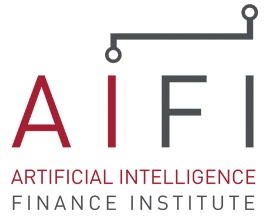


# Bootcamp - Python and Coding - Supervised Machine Learning

## Scikit-Learn Pipeline Example

# About this Notebook

Here we look at a very simple example for using Scikit-learn's `Pipeline`, which is a useful tool for streamlining machine learning workflows by allowing to organize a sequence of data transformations and machine learning operations into a single object. The `Pipeline` combines multiple steps into a single object, enabling to pass data through a sequence of transformations before passing it on to the estimator (machine learning algorithm) for training or prediction. 
- The `Pipeline` object takes a list of tuples, with each tuple specifying the name of the transformation and an instance of the transformation object. 
- The transformations are executed in the order specified by the list of tuples. 
- The `Pipeline` can be used for a range of tasks including data preprocessing, feature engineering, and machine learning model building, and can be used in conjunction with scikit-learn's `GridSearchCV` for hyperparameter tuning.

[Link to documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). 

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import yfinance as yf

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings(action='ignore')


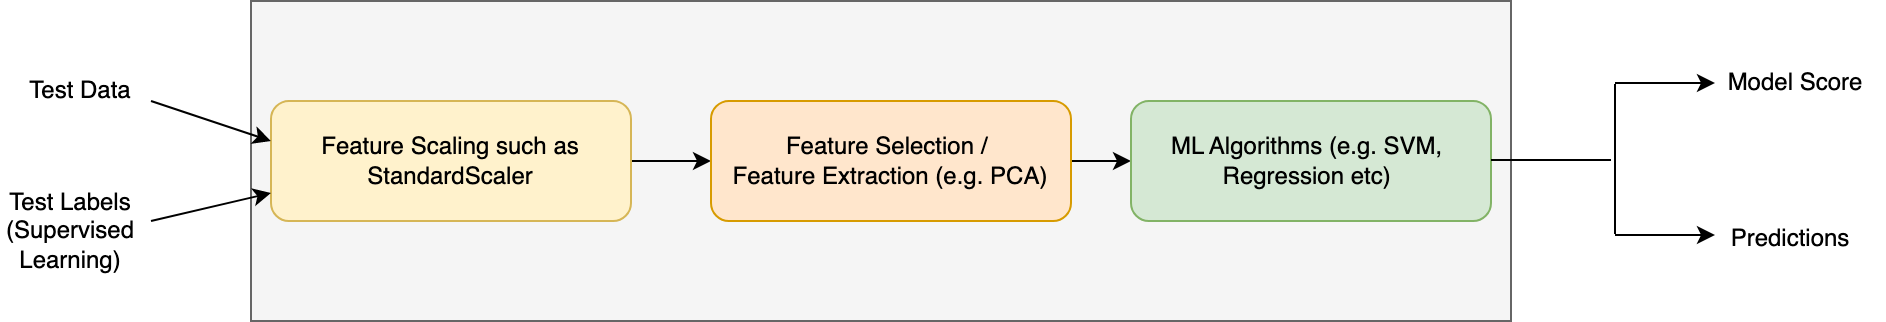

## Get data

In [3]:
# Download TSLA stock data
df = yf.download('TSLA', start='2019-01-01', end='2022-01-01')

[*********************100%***********************]  1 of 1 completed


## Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [4]:
# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

# Define the features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'signal']]
y = df['signal']

## Split data

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

## Create pipeline

In [6]:
# Create the pipelines with the scalers and the classifiers
pipelines = [
    ('svc',
     Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=42))])),
    ('rf',
     Pipeline([('scaler', StandardScaler()),
               ('rf', RandomForestClassifier(random_state=42))])),
    ('gb',
     Pipeline([('scaler', StandardScaler()),
               ('clf', GradientBoostingClassifier(random_state=42))])),
    ('lr',
     Pipeline([('scaler', StandardScaler()),
               ('clf', LogisticRegression(random_state=42))])),
]

## Set hyperparameters for the classifiers

In [7]:
# Set the hyperparameters for the classifiers
hyperparameters = [
    {
        'svc__C': np.logspace(-4, 4, 9),
        'svc__gamma': np.logspace(-4, 4, 9)
    },
    {
        'rf__n_estimators': [10, 50, 100, 200],
        'rf__max_depth': [2, 5, 10, None]
    },
    {
        'clf__n_estimators': [10, 50, 100, 200],
        'clf__learning_rate': np.logspace(-4, 0, 5)
    },
    {
        'clf__C': np.logspace(-4, 4, 9)
    },
]

## Fit the pipelines

In [8]:
# Fit the pipelines with hyperparameter tuning on the training data
best_estimators = []
all_results = []
for i, (name, pipeline) in enumerate(pipelines):
    print(f"Fitting {name}...")
    clf = RandomizedSearchCV(pipeline, hyperparameters[i], n_iter=10, cv=5, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    results = pd.DataFrame(clf.cv_results_)
    results['classifier'] = name
    all_results.append(results)
    best_estimators.append((name, clf.best_estimator_))
    print(f"Best parameters: {clf.best_params_}")
    print(f"Training accuracy: {clf.best_score_}\n")


Fitting svc...
Best parameters: {'svc__gamma': 0.1, 'svc__C': 0.1}
Training accuracy: 0.9973684210526315

Fitting rf...
Best parameters: {'rf__n_estimators': 10, 'rf__max_depth': 2}
Training accuracy: 1.0

Fitting gb...
Best parameters: {'clf__n_estimators': 50, 'clf__learning_rate': 1.0}
Training accuracy: 1.0

Fitting lr...
Best parameters: {'clf__C': 0.1}
Training accuracy: 1.0



## Create dataframe with CV results

In [9]:
# Create a new dataframe from all_results
df = pd.concat(all_results, ignore_index=True)

# Evaluate the performance on the test data
for name, clf in best_estimators:
    score = clf.score(X_test, y_test)
    print(f"{name} accuracy: {score}")

svc accuracy: 0.9973614775725593
rf accuracy: 1.0
gb accuracy: 1.0
lr accuracy: 1.0


In [12]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__gamma,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,...,split4_test_score,mean_test_score,std_test_score,rank_test_score,classifier,param_rf__n_estimators,param_rf__max_depth,param_clf__n_estimators,param_clf__learning_rate,param_clf__C
0,0.013992,0.000767,0.005752,0.000690,0.1,0.1,"{'svc__gamma': 0.1, 'svc__C': 0.1}",1.000000,1.000000,0.986842,...,1.00,0.997368,0.005263,1,svc,NaN,NaN,NaN,NaN,NaN
1,0.015762,0.001575,0.006766,0.000461,0.0001,0.0001,"{'svc__gamma': 0.0001, 'svc__C': 0.0001}",0.644737,0.644737,0.644737,...,0.64,0.643789,0.001895,4,svc,NaN,NaN,NaN,NaN,NaN
2,0.010889,0.001632,0.004557,0.000924,1.0,0.01,"{'svc__gamma': 1.0, 'svc__C': 0.01}",0.644737,0.644737,0.644737,...,0.64,0.643789,0.001895,4,svc,NaN,NaN,NaN,NaN,NaN
3,0.011553,0.001857,0.005620,0.001339,1.0,0.1,"{'svc__gamma': 1.0, 'svc__C': 0.1}",1.000000,1.000000,0.973684,...,1.00,0.994737,0.010526,2,svc,NaN,NaN,NaN,NaN,NaN
4,0.013371,0.000715,0.006125,0.000258,0.0001,0.01,"{'svc__gamma': 0.0001, 'svc__C': 0.01}",0.644737,0.644737,0.644737,...,0.64,0.643789,0.001895,4,svc,NaN,NaN,NaN,NaN,NaN


## Plot results

In [10]:
def plot_classifier_metrics(df, metrics):
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 25), sharex=True)
    for i, metric in enumerate(metrics):
        sns.barplot(x='classifier', y=metric, data=df, ci=None, ax=axes[i])
        axes[i].set_ylabel(metric)
    axes[-1].set_xlabel('Classifier')
    plt.suptitle('Classifier Comparison')
    plt.show()

metrics = ['mean_fit_time','mean_test_score', 'rank_test_score']


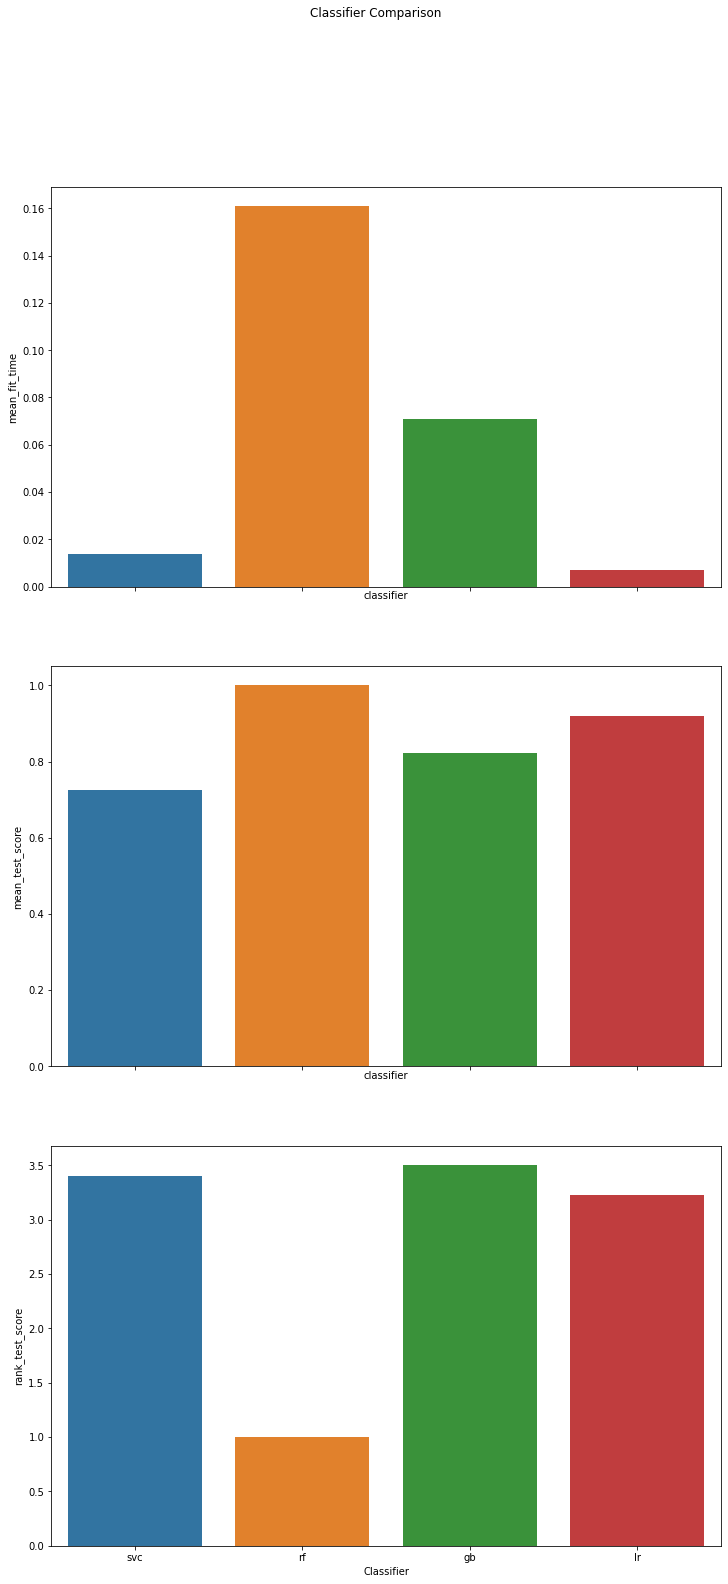

In [11]:
plot_classifier_metrics(df, metrics)